In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [2]:
dataset_dir = "../data/sketchrnn/"
dataset_name = "sketchrnn_airplane.npz"
dict_data = np.load(dataset_dir + dataset_name, encoding='latin1', allow_pickle=True)
# extract the first array

print(dict_data)

NpzFile '../data/sketchrnn/sketchrnn_airplane.npz' with keys: test, train, valid


In [3]:
import utils

train = dict_data['train']
print(train.shape) # we have 70000 sketches
# each seq length varies!

(70000,)


In [4]:
print(train[0].shape, train[1].shape, train[2].shape) # each sketch has a different length

(33, 3) (56, 3) (39, 3)


In [5]:
train[0][1]

array([-52,  -4,   0], dtype=int16)

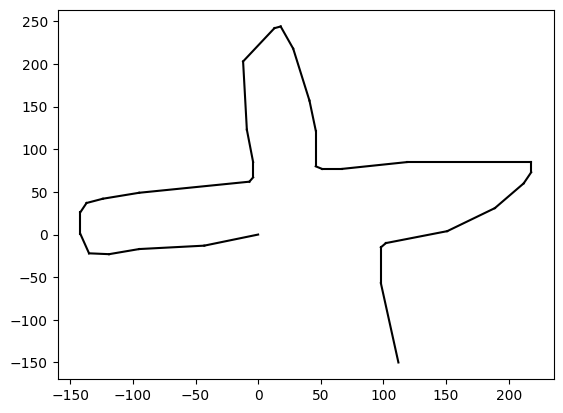

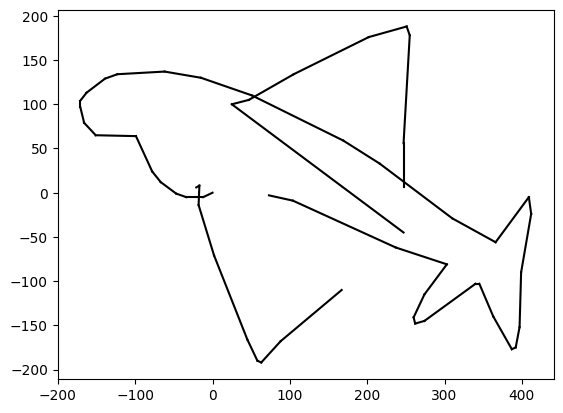

In [6]:
# plot the first 10 sketches

def plot_strokes(strokes):
    plt.figure()
    x = 0
    y = 0
    plt.plot(x, y) # place the pen at the origin
    for i in range(len(strokes)):
        x += strokes[i, 0]
        y += strokes[i, 1]
        if not strokes[i, 2]: # if drawing, i,2 is pen up or down
            plt.plot([x - strokes[i, 0], x], [y - strokes[i, 1], y], 'k')
    plt.show()

for i in range(2):
    sketch = train[i]
    plot_strokes(sketch)
    plt.show()
    

In [8]:
import dezero
from dezero import cuda
from typing import List, Optional, Tuple, Any
import math

class StrokesDataset(dezero.DataLoader):
    def __init__(self, data, batch_size, max_seq_length: int, scale: Optional[float] = None, shuffle=True, gpu=False):
        stroke_data = []
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(data)
        self.max_iter = math.ceil(self.data_size / batch_size)
        self.gpu = gpu
        
        xp = cuda.cupy if self.gpu else np
        
        for seq in data:
            # we will deem a sequence that is less than 10 as too short and thus ignore it
            if 10 < len(seq) <= max_seq_length:
                # clamp the delta x and delta y to [-1000, 1000]
                seq = np.minimum(seq, 1000)
                seq = np.maximum(seq, -1000)
                
                seq = np.array(seq, dtype=np.float32)
                stroke_data.append(seq)
        
        if scale is None:
            # calculate the scale factor
            # the scale factor is the standard deviation of the x and y coordinates
            # mean is not adjusted for simplicity
            # 0:2 means the first two columns of the array which are x and y coordinates
            scale = np.std(np.concatenate([np.ravel(s[:,0:2]) for s in stroke_data]))
        
        longest_seq_len = max([len(seq) for seq in stroke_data])
        
        # we add two extra columns to the dataset since we currently there are only 3 columns in the dataset
        # additional two columns are for changing the last point 1/0 to a one-hot vector
        temp_stroke_dataset = xp.zeros((len(stroke_data), longest_seq_len + 2, 5), dtype=np.float32)
        
        # self.mask is used to mark areas of the sequence that are not used
        # we first initialize it to zero
        temp_mask_dataset = xp.zeros((len(stroke_data), longest_seq_len + 1))
        
        self.dataset = []
        
        # start of sequence is [0, 0, 1, 0, 0]
        
        for i, seq in enumerate(stroke_data):
            seq = xp.array(seq, dtype=xp.float32)
            len_seq = len(seq)
            
            # we start from 1 to leave the first row for the start of sequence token
            temp_stroke_dataset[i, 1:len_seq + 1, 0:2] = seq[:, :2] / scale # this is the x and y coordinates
            temp_stroke_dataset[i, 1:len_seq + 1, 2] = 1 - seq[:, 2] # this is the pen down
            temp_stroke_dataset[i, 1:len_seq + 1, 3] = seq[:, 2] # this is the pen up
            temp_stroke_dataset[i, len_seq + 1, 4] = 1  # this is the end of sequence token
            temp_mask_dataset[i, :len_seq + 1] = 1 # mask is on until the end of the sequence 
            # self.mask is used to mark areas of the sequence that are not used
            # for example, if the sequence is shorter than the longest sequence, we use mask to ignore the rest of the sequence
            # an example of mask is [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        
        temp_stroke_dataset[:, 0, 2] = 1
        
        for i in range(len(stroke_data)):
            self.dataset.append([temp_stroke_dataset[i], temp_mask_dataset[i]])
        
        
        self.reset()


In [9]:
strokes = StrokesDataset(train, batch_size=4, max_seq_length=200, gpu=False, shuffle=False)

In [10]:
print(strokes.data_size)
# first item



x, t = strokes.__next__()
print(x.shape, t.shape) # x is the stroke, t is the mask (x has one more column than t)


# check if the mask is working
batch_size = x.shape[0]

for i in range(batch_size):
    mask_zero_id = np.where(t[i] == 0)[0]
    # first id
    first_id = mask_zero_id[0]
    stroke_end_id = np.where(x[i, :, 4] == 1)[0]
    first_stroke_end_id = stroke_end_id[0]
    
    print(first_id, first_stroke_end_id)


70000
(4, 101, 5) (4, 100)
34 34
57 57
40 40
86 86


In [11]:
import dezero.functions as F

# According to other estimates
# the number of distributions in the mixture model is 20
# https://github.com/Shun14/sketch-rnn-kanji
# https://nn.labml.ai/sketch_rnn/index.html

# This is for getting the loss of delta_x and delta_y
class BivariateGaussianMixture:
    def __init__(self, pi_logits, mu_x, mu_y, sigma_x, sigma_y, rho_xy):
        self.pi_logits = pi_logits
        self.mu_x = mu_x
        self.mu_y = mu_y
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho_xy = rho_xy
    
    @property
    def n_distributions(self):
        return self.pi_logits.shape[-1]
    
    def set_temperature(self, temperature: float):
        self.pi_logits /= temperature
        self.sigma_x *= math.sqrt(temperature)
        self.sigma_y *= math.sqrt(temperature)
    
    def gaussian_pdf(self, x_delta, y_delta):
        # the result means the probability of y in the normal distribution
        # we check the probability of y in the normal distribution
        # if the probability is high, the result is close to 1
        norm1 = F.sub(x_delta, self.mu_x)
        norm2 = F.sub(y_delta, self.mu_y)
        xp = cuda.get_array_module(norm1)

        
        s1s2 = F.mul(self.sigma_x, self.sigma_y)
        
        # This is from: https://github.com/hardmaru/write-rnn-tensorflow/blob/master/model.py
        # z = tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2))
        #     - 2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
         
        # below is the deconstruction of the above linez
        z_first_term = F.pow(F.div(norm1, self.sigma_x), 2)
        z_second_term = F.pow(F.div(norm2, self.sigma_y), 2)
        z_last_term_inner = F.mul(self.rho_xy, F.mul(norm1, norm2))
        z_last_term_middle = F.div(z_last_term_inner, s1s2)
        tmp_z = np.ones(z_last_term_middle.shape) * -2
        z_last_term = F.mul(tmp_z, z_last_term_middle)
        z = F.add(F.add(z_first_term, z_second_term), z_last_term)
        negRho = F.sub(np.ones(self.rho_xy.shape), F.pow(self.rho_xy, 2))

        
        result = F.exp(F.div(-z, 2 * negRho))
        deno_first_term = np.ones(self.sigma_x.shape) * 2 * math.pi
        denom_second_term = F.mul(s1s2, F.pow(negRho, 0.5))
        denom = F.mul(deno_first_term, denom_second_term)
        result = F.div(result, denom)
        
        return result

    # x1_data and x2_data are the real x and y coordinates of the stroke
    def get_lossfunc(self, x_delta, y_delta):
        result0 = self.gaussian_pdf(x_delta, y_delta)
        
        elipson = 1e-20
        # check if result0 has inf or nan
        result1 = F.mul(result0, self.pi_logits)
        result1 = F.sum(result1, axis=1, keepdims=True)
        result1 = -F.log(result1)
        
        return F.mean(result1)
    
    def get_pi_idx(self, x):
        pdf = self.pi_logits
        N = self.size
        accumulate = 0
        for i in range(0, N):
            accumulate += pdf[i]
            if accumulate >= x:
                return i
        print('error with sampling ensemble')
        return -1
    
    # M means the number of samples
    def sample(self, count, M=15):
        xp = cuda.get_array_module(self.pi_logits)
        # get the index of the distribution
        
        result = xp.random.rand(count, M, 2) # initially random [0,1]
        # we will get result for delta_x and delta_y
        rn = xp.random.rand(count, M, 2) 
        mu = 0
        std = 0
        idx = 0
        
        for j in range(M):
            for i in range(count):
                idx = self.get_pi_idx(result[i, j, 0])
                mu = [self.mu_x[i, idx], self.mu_y[i, idx]]
                std = [self.sigma_x[i, idx], self.sigma_y[i, idx]]
                rho = self.rho_xy[i, idx]
                
                result[i, j, 0:2] = mu + rn[i, j] * std
        return result
        
        

        

In [12]:
import dezero.models as M
import dezero.layers as L

class EncoderRNN(M.Model):
    # d_z is the number of dimensions of the latent variable
    def __init__(self, d_z, enc_hidden_size):
        super().__init__()
        self.lstm = L.LSTM(enc_hidden_size, 5) # number of input for lstm is 5
        self.mu_head = L.Linear(d_z)
        self.sigma_head = L.Linear(d_z)
    
    
    def forward(self, x, state=None):
        h, cell = self.lstm(x) # x is the stroke data 
        
        mu = self.mu_head(h)
        
        sigma_hat = self.sigma_head(h)
        
        sigma = F.exp(F.div(sigma_hat, 2))
        
        xp = cuda.get_array_module(mu)
        
        z = mu + sigma * xp.random.normal(0, 1, mu.shape) # reparameterization trick
        
        return z, mu, sigma
        

In [13]:
class DecoderRNN(M.Model):
    def __init__(self, d_z: int, dec_hidden_size: int, n_distributions: int):
        super().__init__()
        # we add 5 to the input size because we are adding the latent variable to the input
        self.lstm = L.LSTM(dec_hidden_size, d_z + 5)
        self.init_state = L.Linear(2 * dec_hidden_size, d_z) # initial state of lstm is [h0;c0] = tanh(Wz * z + bz)
        self.mixtures = L.Linear(6 * n_distributions, dec_hidden_size)
        self.q_head = L.Linear(3, dec_hidden_size) # this is for logit q1 and q2 and q3
        self.q_log_softmax = F.LogSoftmax(-1) 
        
        self.n_distributions = n_distributions
        self.n_hidden = dec_hidden_size
    
    def forward(self, x, z, state = None):
        xp = cuda.get_array_module(x)
        if state is None:
            temp = F.tanh(self.init_state(z))
            # split the state into h and c into n_hidden groups
            h, c = xp.split(temp, self.n_hidden, axis=1)
            # make h and c into 1d array
            state = (h.ravel(), c.ravel())
        
        outputs, state = self.lstm(x, state)
        
        q_logits = self.q_log_softmax(self.q_head(outputs))
        
        pi_logts, mu_x, mu_y, sigma_x, sigma_y, rho_xy = xp.split(self.mixtures(outputs), self.n_distributions, axis=2)
        
        BGM = BivariateGaussianMixture(pi_logts, mu_x, mu_y, sigma_x, sigma_y, rho_xy)
        
        return BGM, q_logits, state

In [14]:

class ReconstructionLoss(M.Model):
    # mask is the mask for the sequence,
    # for example, [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]: this means the first 3 points are used
    def forward(self, mask, target, bgm, q_logits):
        xp = cuda.get_array_module(mask)
        # target is a 3 dimensional array
        # xy = target[:, :, 0:2].unsqueeze(-2).expand(-1, -1, dist.n_distributions, -1)
        xy = target[:, :, 0:2]
        xy = xy[:, :, xp.newaxis, :]
        
        expanded_shape = (xy.shape[0], xy.shape[1], bgm.n_distributions, xy.shape[3])
        
        x = xp.tile(xy, expanded_shape)
        y = xp.tile(xy, expanded_shape)
        
        loss_stroke = F.mul(bgm.get_lossfunc(x, y), mask)
        
        loss_pen = -F.mean(F.mul(target[:,:,2:], q_logits))
        
        return F.add(loss_stroke, loss_pen)
        

In [15]:
class KLDivergenceLoss(M.Model):
    def forward(self, mu, sigma):
        xp = cuda.get_array_module(mu)
        tmp = xp.ones(sigma.shape)
        inner_1 = F.add(tmp, sigma)
        inner_2 = F.add(F.pow(mu, 2), F.exp(sigma))
        inner = F.sub(inner_1, inner_2)
        tmp2 = xp.ones(inner.shape) * -2
        return F.mean(F.div(inner, tmp2))
        

In [16]:
class Sampler:
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder
    
    def sample(self, x, n_samples=1, temperature=1.0):
        longest_seq_len = len(x)
        
        z, _, _ = self.encoder(x)
        xp = cuda.get_array_module(x)
        s = xp.zeros((n_samples, 1, 5), dtype=self.xp.float32)
        s[:, 0, 2] = 1
        seq = xp.array(s, dtype=xp.float32)
        
        state = None
        
        with dezero.no_grad():
            for i in range(longest_seq_len):
                s_modified = s.view(1, 1, -1)
                unsqueezed_z = xp.expand_dims(z, axis=0)
                data = xp.concatenate([s_modified, unsqueezed_z], axis=2)
                
                bgm, q_logtis, state = self.decoder(data, z, state)
                

                
    def _sample_step(bgm, q_logits, temperature):
        xp = cuda.get_array_module(x)
        bgm.set_temperature(temperature)
        gen_result = bgm.sample()
        
        # we need categorical distribution q for pen state
        # convert scaled logits to probabilities
        probabilities = F.softmax(q_logits / temperature, axis=-1)
        
        gen_x = gen_result[:, :, 0]
        gen_y = gen_result[:, :, 1]
        
        # sample from categorical distribution
        # we need to sample from the pen state
        stroke = xp.zeros(5, dtype=q_logits.dtype)
        
        # fill in gen_x and gen_y
        stroke[:, 0] = gen_x
        stroke[:, 1] = gen_y
        
        # sample from the categorical distribution
        # we need to sample from the pen state
        pen = xp.random.choice(3, 1, p=probabilities)
        
        stroke[:, 2 + pen] = 1
        
        return stroke
        
        
        

In [17]:
# train

enc_hidden_size = 256
dec_hidden_size = 512

batch_size = 4
# Number of features in z (latent variable)
d_z = 128
n_distribution = 20
kl_div_loss_weight = 0.5
grad_clip = 1.0
temperature = 0.4
max_seq_length = 200

epochs = 5

kl_div_loss = KLDivergenceLoss()
recon_loss = ReconstructionLoss()

class VAE(M.Model):
    def __init__(self):
        super().__init__()
